# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
#!pip install git+http://github.com/scikit-learn/scikit-learn.git

In [2]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
from sqlalchemy import create_engine
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
    
import pickle
    
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidhartmann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidhartmann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davidhartmann/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidhartmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# load data from database
def load_data(database_filepath):
    """ Load data from Sqlite database into DataFrame
        INPUTS:
        ------------
        database_filepath - path to Sqlite database
        
        OUTPUTS:
        ------------
        X - input features (messages) of DataFrame df
        Y - categories of DataFrame df
        category_names - list of category names (column names of Y)
        
    """
    engine = create_engine('sqlite:///'+ database_filepath)
    df = pd.read_sql("SELECT * FROM disaster", engine)
    
    # X and y
    colnames = df.columns.tolist()
    category_names = colnames[4:]

    X = df.message.values
    Y = df[category_names]
    
    # Show DataFrame result, shapes, colnames, target
    print('DATAFRAME df')
    print(df.head())
    print('Shape of df: ' + str(df.shape))
    print(' ')
   
    print('DATAFRAME Y')
    print(Y)
    print('Shape of Y: ' + str(Y.shape))
    print(' ')
    
    print('colnames')
    print(colnames)
    print(' ')
    
    print('category_names')
    print(category_names)
    print(' ')
    
    return X, Y, category_names, df

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    """ function that will 
        - replace urls via placeholder,
        - tokenize words, 
        - Remove stop words,
        - Lemmatize, normalize all words to lower case, remove white spaces 
         
        INPUTS:
        ------------
        text - text as string
        
        OUTPUTS:
        ------------
        clean_tokens - a list of cleaned words
    
    """
    # Detect URLs
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]  
    
    # Lemmatize, normalize all words to lower case, remove white spaces 
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        
    return clean_tokens

### 3. Custom Transformer classes
Let's create Custom Transformer classes to implement special NLP pipelines.

In [5]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """ To know the parts of speech (like nouns, verbs, pronouns) 
        can help to understand the meaning of a sentence better.
        This class checks if the first word of a sentence is a verb.
        if yes --> return True
        if no --> return False
    
    """
    def starting_verb(self, text):
        """ function that 
            - divides a text string into a list of sentences 
            - checks if the first word of a sentence is a verb
            
            INPUTS: 
            ------------
            text - a string of text
            
            OUTPUTS:
            ------------
            True - if verb
            False - if anything else than verb
        """
            
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        """ fit function for estimator (object that learns from data), 
            here estimator is an instance of StartingVerbExtractor class
            
            INPUTS:
            ------------
            x - 2d array X of the dataset features  
            y - 1d array y of the dataset target labels
            
            OUTPUTS
            ------------
            self - allows to chain methods together. This method is required to be compatible with scikit-learn
        """
        return self

    def transform(self, X):
        """ function which includes the code to transform the data
            
            INPUTS:
            ------------
            x - 2d array X of the dataset features
            
            OUTPUTS:
            ------------
            df_x_tagged - a DataFrame of X_tagged (containing a column with True and False values) 
                          this transformer object will be appendend to the pipeline object via Feature Union
        """
        X_tagged = pd.Series(X).apply(self.starting_verb)
        df_x_tagged = pd.DataFrame(X_tagged)
        return df_x_tagged

In [6]:
class NamedEntityRecognition(BaseEstimator, TransformerMixin):
    """ Named entities are typically noun phrases that refer to some specific object, person, or place
        NLTK provides the ne_chunk function to label named entities in text
        Before using ne_chunk one has to
        - first tokenize and then
        - tag parts of speech

    """
    def get named_entities(self, text):
        """ function that 
            - divides a text string into a list of sentences 
            - checks if the first word of a sentence is a verb
            
            INPUTS: 
            ------------
            text - a string of text
            
            OUTPUTS:
            ------------
            True - if verb
            False - if anything else than verb
        """
            
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        """ fit function for estimator (object that learns from data), 
            here estimator is an instance of StartingVerbExtractor class
            
            INPUTS:
            ------------
            x - 2d array X of the dataset features  
            y - 1d array y of the dataset target labels
            
            OUTPUTS
            ------------
            self - allows to chain methods together. This method is required to be compatible with scikit-learn
        """
        return self

    def transform(self, X):
        """ function which includes the code to transform the data
            
            INPUTS:
            ------------
            x - 2d array X of the dataset features
            
            OUTPUTS:
            ------------
            df_x_tagged - a DataFrame of X_tagged (containing a column with True and False values) 
                          this transformer object will be appendend to the pipeline object via Feature Union
        """
        X_tagged = pd.Series(X).apply(self.starting_verb)
        df_x_tagged = pd.DataFrame(X_tagged)
        return df_x_tagged

SyntaxError: invalid syntax (<ipython-input-6-7101728ae013>, line 9)

### 4 Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In order to successfully predict classification results for the 36 categories a pipeline helps to organize data preporcessing and data flow based on ETL and NLP.
The used pipeline is structured in the following way:

In [7]:
def build_model(X_train, Y_train, pipeline_name='pipeline_1'):
    """ Build a ML pipelines
        Test different pipelines
        - pipeline_1: standard based on CountVectorizer, TfidfTransformer and MultiOutputClassifier
        - pipeline_2: as pipeline_1 but use GridSearchCV to find optimized parameters
        - pipeline_3: add CustomTransformer StartingVerbExtractor into pipeline
        
        INPUTS:
        ------------
        pipeline_name - string name for calling a specific pipeline
        X_train - input features for training 
        Y_train - target values 
        
        OUTPUTS:
        ------------
        pipeline - sklearn pipeline object which is ETL and NLP 'pipelined', i.e. 
        - tokenization (see tokenize() method), 
        - Transformer method: vecorization via CountVectorizer 
        - Transformer method: tfidf (matrix of weights product, i.e. term frequency times inverse document frequency)
        - Predictor method: MultiOutputClassifier(RandomForestClassifier()) - used to get predictions for each category
        
    """
    if pipeline_name == 'pipeline_1':
        print('pipeline_1 chosen')
        pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier())),
                #('clf', SGDClassifier()),
            ])
        return pipeline
       
    
    if pipeline_name == 'pipeline_2':
        print('pipeline_2 chosen')
        pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier()))
                #('clf', SGDClassifier()),
            ])
        
        # uncommenting more parameters will give better exploring power but will
        # increase processing time in a combinatorial way
        parameters = {
            'vect__max_df': (0.5, 0.75, 1.0),
            # 'vect__max_features': (None, 5000, 10000, 50000),
            'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
            # 'tfidf__use_idf': (True, False),
            # 'tfidf__norm': ('l1', 'l2'),
            #'clf__estimator__min_samples_split': [2, 4],
            #'clf__estimator__max_features': ['log2', 'auto', 'sqrt', None],
            #'clf__estimator__criterion': ['gini', 'entropy'],
            #'clf__estimator__max_depth': [None, 25, 50, 100, 150, 200],

            # FOR SGDClassifier():
            #'clf__max_iter': (20,),
            #'clf__alpha': (0.00001, 0.000001),
            #'clf__penalty': ('l2', 'elasticnet'),
            # 'clf__max_iter': (10, 50, 80),
        }
        cv = GridSearchCV(estimator=pipeline, param_grid=parameters)
        cv.fit(X_train, Y_train)
        return cv

        
    if pipeline_name == 'pipeline_3':
        print('pipeline_3 chosen')
        pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            ('starting_verb', StartingVerbExtractor())
        ])),

        ('clf', MultiOutputClassifier(RandomForestClassifier()))
        ])

        parameters = {
            'features__text_pipeline__vect__ngram_range': ((1, 1), (1, 2)),
            'features__text_pipeline__vect__max_df': (0.5, 0.75, 1.0),
            'features__text_pipeline__vect__max_features': (None, 5000, 10000),
            'features__text_pipeline__tfidf__use_idf': (True, False),
            'clf__estimator__n_estimators': [50, 100, 200],
            'clf__estimator__min_samples_split': [2, 3, 4],
            'features__transformer_weights': (
                {'text_pipeline': 1, 'starting_verb': 0.5},
                {'text_pipeline': 0.5, 'starting_verb': 1},
                {'text_pipeline': 0.8, 'starting_verb': 1},
            )
        }
        
        cv = GridSearchCV(estimator=pipeline, param_grid=parameters)
        cv.fit(X_train, Y_train)
        return cv

In [11]:
def evaluate_model(model, X_test, Y_test, category_names, pipeline_name):
    """ Get a classification report from testing results including precision, recall, f1-score an accuracy 
        
        INPUTS:
        ------------
        model - the trained model based on the actual pipeline
        X_test - DataFrame with test input features 
        Y_test - DataFrame of true target values 
        
        OUTPUTS:
        ------------
        print statements for precision, recall, f1-score an accuracy for each category
    """
    # Make predictions based on trained model
    Y_pred = model.predict(X_test)
    
    #print(classification_report(y_test, y_pred, target_names=y_test.keys()))
    accuracy = (Y_pred == Y_test).mean()
    df_classification_report = pd.DataFrame(classification_report(Y_test, Y_pred, target_names=Y_test.keys(),  output_dict=True))
    df_classification_report = pd.concat([df_classification_report.T, accuracy], axis=1).reindex(df_classification_report.T.index)
    df_classification_report.columns = ['f1_score', 'precision', 'recall', 'support', 'accuracy']
    print(pipeline_name)
    print(df_classification_report)
    print(' ')
    print('Total accuracy = ' + str(round(accuracy.mean(),2)))
    print(' ')

### 5. Train pipeline
- Split data into train and test sets
- Train pipeline

In [8]:
def save_model(model, model_filepath):
    """ Save the model
        
        INPUTS:
        ------------
        model: model to be saved
        model_filepath: filepath to model
        
        OUTPUTS:
        ------------
        save model as a pickle file
    """  
    pickle.dump(model, open(model_filepath, 'wb'))

In [12]:
def main():
    """ Main function to trigger model training, model evaluation and model saving
        Function that tiggers 
        - load_data
        - train_test_split
        - build_model
        - model.fit 
        - evaluate_model
        - save_model
    
        INPUTS:
        ------------
        No direct inputs, however there are three pipelines to bes tested in build_model.
        These pipelines are called via the pipeline_names list 
        
        OUTPUTS:
        ------------
        no odirect outputs, however the model is stored as a pickle file to disk
        
    """
   
    database_filepath = 'disaster.db'
    model_filepath = 'models/classifier.pkl'
    print('Loading data...\n    DATABASE: {}'.format(database_filepath))
    X, Y, category_names, df = load_data(database_filepath)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    pipeline_names = ['pipeline_1']
    for pipeline_name in pipeline_names:
        print('Building model...')
        model = build_model(X_train, Y_train, pipeline_name)

        print('Training model...')
        model.fit(X_train, Y_train)

        print('Evaluating model...')
        evaluate_model(model, X_test, Y_test, category_names, pipeline_name)

        path, filename = os.path.split(model_filepath)
        base, ext  = os.path.splitext(filename)
        model_filepath = os.path.join(path, base + '_' + pipeline_name + '.pkl')
        print('Saving model...\n    MODEL: {}'.format(model_filepath))
        save_model(model, model_filepath)

        print('Trained model saved!')

main()

Loading data...
    DATABASE: disaster.db
DATAFRAME df
   id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   

   request  offer  aid_related  medical_help  medical_products  ...  \
0        0      0            0             0                 0  ...   
1  

Evaluating model...


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/anaconda3/

pipeline_1
                        f1_score  precision    recall  support  accuracy
related                 0.881593   0.844843  0.921685   4035.0  0.808106
request                 0.565217   0.814255  0.432836    871.0  0.888590
offer                   0.000000   0.000000  0.000000     29.0  0.994430
aid_related             0.649037   0.741349  0.577169   2190.0  0.737418
medical_help            0.218182   0.540541  0.136674    439.0  0.917403
medical_products        0.111455   0.750000  0.060201    299.0  0.944871
search_and_rescue       0.067568   0.833333  0.035211    142.0  0.973492
security                0.019048   1.000000  0.009615    104.0  0.980215
military                0.099448   0.562500  0.054545    165.0  0.968690
child_alone             0.000000   0.000000  0.000000      0.0  1.000000
water                   0.502008   0.816993  0.362319    345.0  0.952363
food                    0.636550   0.815789  0.521886    594.0  0.932002
shelter                 0.393798   0.774

### 6. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

### --> see build_model --> pipeline_1

### 7. Improve your model
Use grid search to find better parameters. 

### --> see build_model --> pipeline_2

### 8. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 9. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### --> see build_model --> pipeline_3

### 10. Export your model as a pickle file

### see save_model

### 11. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

### 12. Evaluation 

This is the last but very important part of a CRISP-DM analysis. In this section the following impoortant business questions will be answered:

- Question 1: How are the three different 'genre' types distributed?
- Question 2: What is the distribution of letters-count for each genre? Are there any outliers?
- Question 3: What is the distribution of words-counts for each genre? Are there any outliers?

### Load the data

In [19]:
database_filepath = 'disaster.db'
model_filepath = 'models/classifier.pkl'
X, Y, category_names, df = load_data(database_filepath)

DATAFRAME df
   id                                            message  \
0   2  Weather update - a cold front from Cuba that c...   
1   7            Is the Hurricane over or is it not over   
2   8                    Looking for someone but no name   
3   9  UN reports Leogane 80-90 destroyed. Only Hospi...   
4  12  says: west side of Haiti, rest of the country ...   

                                            original   genre  related  \
0  Un front froid se retrouve sur Cuba ce matin. ...  direct        1   
1                 Cyclone nan fini osinon li pa fini  direct        1   
2  Patnm, di Maryani relem pou li banm nouvel li ...  direct        1   
3  UN reports Leogane 80-90 destroyed. Only Hospi...  direct        1   
4  facade ouest d Haiti et le reste du pays aujou...  direct        1   

   request  offer  aid_related  medical_help  medical_products  ...  \
0        0      0            0             0                 0  ...   
1        0      0            1             0 

#### Question 1: How are the three different 'genre' types distributed?

In [59]:
import plotly.graph_objects as go

# as a bar chart    
graph = []
# extract data needed for visuals
genre_counts = df.groupby('genre').count()['message']
genre_names = list(genre_counts.index)

graph.append(
  go.Bar(
  x = genre_names,
  y = genre_counts,
  )
)

layout = dict(title = 'Distribution of Message genres',
            xaxis = dict(title = 'Count',),
            yaxis = dict(title = 'Genre'),
            )

# append all charts to the figures list
figures = []
figures.append(dict(data=graph, layout=layout))
#figures.append(dict(data=graph_two, layout=layout_two))

fig = go.Figure(figures[0])

fig.show()

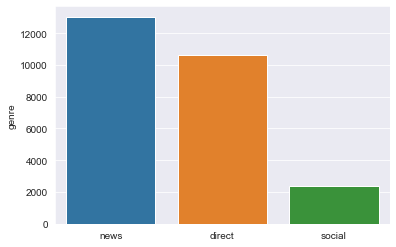

In [30]:
# Alternative to plotly: Values counts for type of message
df['genre'].value_counts()
sns.barplot(x=df['genre'].value_counts().index, y=df['genre'].value_counts());

#### Question 2: What is the distribution of letters-count for each genre? Are there any outliers?

In [60]:
# as a Boxplot    

graph = []
# extract data needed for visuals
message_length_direct = df[df['genre'] == 'direct']['message'].apply(lambda x: len(x))
message_length_news = df[df['genre'] == 'news']['message'].apply(lambda x: len(x))
message_length_social = df[df['genre'] == 'social']['message'].apply(lambda x: len(x))
messages_box = [('direct', message_length_direct), ('news', message_length_news), ('social', message_length_social)]

graph = [go.Box(y=message_length, name=message_type) for message_type, message_length in messages_box]
    
layout = dict(title = 'Letters-count descriptive stats for each genre')

# append all charts to the figures list
figures = []
figures.append(dict(data=graph, layout=layout))

fig = go.Figure(figures[0])

fig.show()

In [61]:
# as a Histogram    

graph = []
# extract data needed for visuals
message_length_direct = df[df['genre'] == 'direct']['message'].apply(lambda x: len(x))
message_length_news = df[df['genre'] == 'news']['message'].apply(lambda x: len(x))
message_length_social = df[df['genre'] == 'social']['message'].apply(lambda x: len(x))
messages_box = [('direct', message_length_direct), ('news', message_length_news), ('social', message_length_social)]

graph = [go.Histogram(x=message_length, name=message_type) for message_type, message_length in messages_box]
    
layout = dict(title = 'Letters-count distribution for each genre',
                    #xaxis = dict(type='log'),
                    yaxis = dict(title = 'Count', type='log'),
                    )

# append all charts to the figures list
figures = []
figures.append(dict(data=graph, layout=layout))

fig = go.Figure(figures[0])
#fig.update_layout(yaxis_type="log") 
fig.show()

#### Question 3: What is the distribution of words-counts for each genre? Are there any outliers?

In [71]:
# as a Boxplot    

graph = []
# extract data needed for visuals
message_length_direct = df[df['genre'] == 'direct']['message'].apply(lambda x: len(tokenize(x)))
message_length_news = df[df['genre'] == 'news']['message'].apply(lambda x: len(tokenize(x)))
message_length_social = df[df['genre'] == 'social']['message'].apply(lambda x: len(tokenize(x)))
messages_box = [('direct', message_length_direct), ('news', message_length_news), ('social', message_length_social)]

graph = [go.Box(y=message_length, name=message_type) for message_type, message_length in messages_box]
    
layout = dict(title = 'Word-count descriptive stats for each genre')

# append all charts to the figures list
figures = []
figures.append(dict(data=graph, layout=layout))

fig = go.Figure(figures[0])

fig.show()

In [70]:
# as a Histogram    

graph = []
# extract data needed for visuals
# 
graph = [go.Histogram(x=message_length, name=message_type) for message_type, message_length in messages_box]
    
layout = dict(title = 'Word-count distribution for each genre',
                    #xaxis = dict(type='log'),
                    yaxis = dict(title = 'Count', type='log'),
                    )

# append all charts to the figures list
figures = []
figures.append(dict(data=graph, layout=layout))

fig = go.Figure(figures[0])
#fig.update_layout(yaxis_type="log") 
fig.show()

#### Question 5: Are there any significant correlations between the categories?

In [64]:
# as a bar Corrlation plot    

graph = []
# extract data needed for visuals
corr_x = df.corr().index
corr_y = df.corr().index

graph.append(go.Heatmap(
                    x=corr_x,
                    y=corr_y,
                    z=df.corr().values,
                    type = 'heatmap',
                    colorscale = 'Viridis')
            )
    
layout = dict(title = 'Correlation matrix',
                    xaxis = dict(automargin=True),
                    yaxis = dict(automargin=True),
             )

# append all charts to the figures list
figures = []
figures.append(dict(data=graph, layout=layout))

fig = go.Figure(figures[0])
#fig.update_layout(yaxis_type="log") 
fig.show()